In [30]:
#### 导包
import torch, os
from torch import nn
import numpy as np
import warnings 
# Filter Warnings 
warnings.filterwarnings('ignore')
from PIL import Image
%matplotlib inline
import matplotlib.pyplot as plt 
import pandas as pd
import glob, os
from torchvision import transforms
from sklearn.model_selection import train_test_split

In [31]:
#### 查看cuda是否可用
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

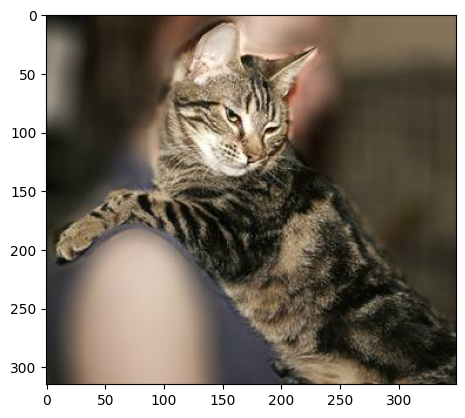

In [32]:
####   读取一张图片 画出该图片
image = Image.open('./training_set/training_set/cats/cat.1023.jpg')
plt.imshow(np.asarray(image))

In [33]:
###   获取该图片的尺寸
np.asarray(image).shape

(315, 349, 3)

In [34]:
####  定义图片的长宽均值以及标准差
IMG_WIDTH = 224 
IMG_HEIGHT = 224 
mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]
####   ####   请同学自己完成图片增强代码，进行图片增强
transform =  transforms.Compose([
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)), #前面有resize了
    transforms.RandomResizedCrop(IMG_WIDTH),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])
####  增强后的图片的形状
img_transformed = transform(image)
img_transformed.shape

torch.Size([3, 224, 224])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


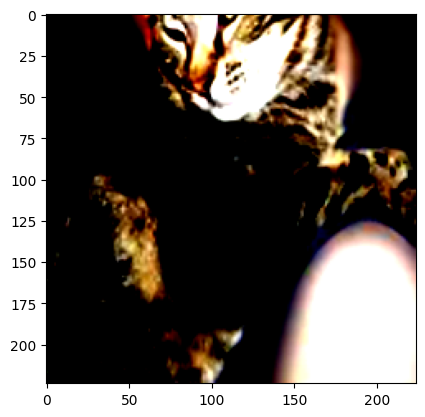

In [35]:
####   显示增强后的图片
plt.imshow(img_transformed.permute(1, 2, 0))

In [36]:
#########    训练集和验证集的路径
PATH_TRAIN_CAT = './training_set/training_set/cats'
PATH_TRAIN_DOG = './training_set/training_set/dogs'
PATH_TEST_CAT = './test_set/test_set/cats'
PATH_TEST_DOG = './test_set/test_set/dogs' 
####   定义猫狗标签进行映射 
DOG = 0
CAT = 1

NR_PIX = IMG_HEIGHT * IMG_WIDTH
NR_CHANELS = 3 # 全彩RGB
NR_FEATURES = NR_PIX * NR_CHANELS 

In [37]:
####   显示训练集图片路径以及标签
train_df = pd.DataFrame(columns=['image_files', 'labels'])
train_cat_list = glob.glob(os.path.join(PATH_TRAIN_CAT,'*.jpg'))
train_dog_list = glob.glob(os.path.join(PATH_TRAIN_DOG,'*.jpg'))
train_df['image_files'] = train_cat_list + train_dog_list
train_df['labels'] = ([CAT]*len(train_cat_list)) + ([DOG]*len(train_dog_list))
pd.set_option('max_colwidth', 400)
#train_df = train_df.sample(frac=1).reset_index(drop=True)
train_df

,image_files,labels
0,./training_set/training_set/cats\cat.1.jpg,1
1,./training_set/training_set/cats\cat.10.jpg,1
2,./training_set/training_set/cats\cat.100.jpg,1
3,./training_set/training_set/cats\cat.1000.jpg,1
4,./training_set/training_set/cats\cat.1001.jpg,1
...,...,...
8000,./training_set/training_set/dogs\dog.995.jpg,0
8001,./training_set/training_set/dogs\dog.996.jpg,0
8002,./training_set/training_set/dogs\dog.997.jpg,0
8003,./training_set/training_set/dogs\dog.998.jpg,0


In [38]:
#####划分数据集
train, val = train_test_split(train_df, test_size=0.2, random_state=42, stratify=train_df['labels'])

In [39]:
#### 构建dataset类
class CatDog_dataset:
    def __init__(self, images, labels, transform):
        self.images = images
        self.labels = torch.FloatTensor(labels).view(-1, 1)
        self.transform = transform
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]
        img = Image.open(img_path)
        img = self.transform(img)
        return img, label

In [40]:
####   批训练，把数据变成一小批一小批数据进行训练。 DataLoader就是用来包装所使用的数据，每次抛出一批数据
train_dataset = CatDog_dataset(train['image_files'].tolist(), train['labels'].tolist(), transform)
val_dataset = CatDog_dataset(val['image_files'].tolist(), val['labels'].tolist(), transform)
batch_size = 128
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [41]:
# 创建简单的CNN模型
class CNN_Model(nn.Module):
    def __init__(self):
        super().__init__()
        # Convolution 1,input_shape=(3,224,224)
        self.cnn1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5) 
        # Convolution 2
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3) 
        self.cnn3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3) 
        
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        self.fc = nn.Linear(64*26*26, 1) 
    
    def forward(self, x):
        # Convolution 1, input_shape=(3,224,224)
        out = self.cnn1(x) #output_shape=(16,220,220)
        out = self.relu(out)
        out = self.maxpool(out) #output_shape=(16,110,110)
        
        # Convolution 2 
        out = self.cnn2(out) #output_shape=(32,108,108)
        out = self.relu(out)
        out = self.maxpool(out) #output_shape=(32,54,54)
        
        # Convolution 3 
        out = self.cnn3(out) #output_shape=(64,52,52)
        out = self.relu(out)
        out = self.maxpool(out) #output_shape=(64,26,26)
        
        out = torch.flatten(out, start_dim=1) #拉平
        #out = out.view(1, -1) 
        # Linear function (readout)
        # Fully connected,#input_shape=(32*54*54)
        out = self.fc(out)
        return out

In [42]:
# #from torchinfo import summary

# batch_size = 16
#summary(model, input_size=(batch_size, 3,224,224))

In [43]:
## 训练和验证
epochs = 200
def train(model):
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    loss_function = nn.BCEWithLogitsLoss(reduction='sum')
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=0.01)


    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        train_loss = 0
        corrects = 0
        for i, (datas, labels) in enumerate(train_loader):
            datas = datas.to(device)
            labels = labels.to(device)
            outputs = model(datas)
            loss = loss_function(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            predicted = torch.sigmoid(outputs).round().cpu().detach().numpy()
            corrects += (predicted == labels.cpu().detach().numpy()).sum()      
        train_losses.append(train_loss/len(train_dataset))
        train_accuracies.append(corrects*100/len(train_dataset))
        print(f'Epoch:{epoch}, train_accuracy:{train_accuracies[-1]}%, train_losses:{train_losses[-1]}', end='.')
        with torch.no_grad():
            val_loss = 0
            corrects = 0
            for i, (datas, labels) in enumerate(val_loader):
                datas = datas.to(device)
                labels = labels.to(device)
                outputs = model(datas)
                loss = loss_function(outputs, labels)

                val_loss += loss.item()
                predicted = torch.sigmoid(outputs).round().cpu().detach().numpy()
                corrects += (predicted == labels.cpu().detach().numpy()).sum()
            val_losses.append(val_loss/len(val_dataset))
            val_accuracies.append(corrects*100/len(val_dataset))
            print(f', val_accuracy:{val_accuracies[-1]}%, val_losses:{val_losses[-1]}')
    return train_losses, train_accuracies, val_losses, val_accuracies

In [44]:
#### 创建模型实例  将模型加载至GPU中
model = CNN_Model()
model.to(device)
#### 返回训练验证损失及训练验证准确度
train_losses, train_accuracies, val_losses, val_accuracies =  train(model)

Epoch:0, train_accuracy:53.7788881948782%, train_losses:0.6871150471060667., val_accuracy:59.96252342286071%, val_losses:0.6707003925235326
Epoch:1, train_accuracy:59.993753903810116%, train_losses:0.6669102720288022., val_accuracy:61.961274203622736%, val_losses:0.6529178226239826
Epoch:2, train_accuracy:60.04059962523423%, train_losses:0.6625761374468211., val_accuracy:62.46096189881324%, val_losses:0.6515383032394304
Epoch:3, train_accuracy:62.054965646470954%, train_losses:0.6520666889218075., val_accuracy:65.20924422236102%, val_losses:0.6286898654077591
Epoch:4, train_accuracy:62.695190505933795%, train_losses:0.6464285831165493., val_accuracy:63.897564022485945%, val_losses:0.6340198647894016
Epoch:5, train_accuracy:62.7264209868832%, train_losses:0.6386224837097654., val_accuracy:63.27295440349781%, val_losses:0.6310499216302494
Epoch:6, train_accuracy:63.94440974391006%, train_losses:0.6314465348084668., val_accuracy:65.27170518425984%, val_losses:0.6220358777686553
Epoch:7, t

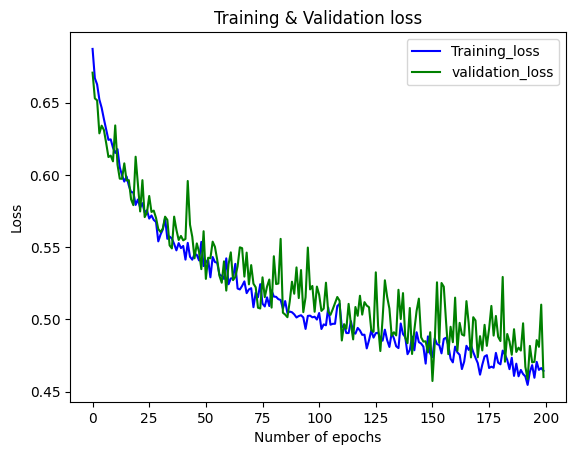

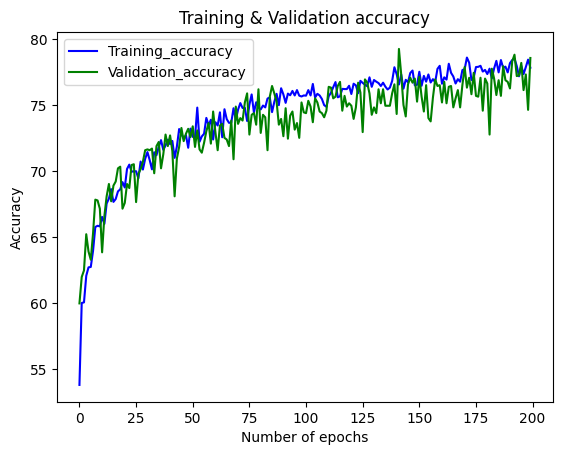

In [45]:
# 可视化
plt.plot(range(epochs), train_losses, 'b-', label='Training_loss')
plt.plot(range(epochs), val_losses, 'g-', label='validation_loss')
plt.title('Training & Validation loss')
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
###  请同学们画出训练准确率以及验证准确率的图
plt.plot(range(epochs), train_accuracies, 'b-', label='Training_accuracy')
plt.plot(range(epochs), val_accuracies, 'g-', label='Validation_accuracy')
plt.title('Training & Validation accuracy')
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#迁移学习

In [46]:
#####  导包
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms
import torch.optim as optim
from torchvision import models
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import random
import warnings
warnings.filterwarnings("ignore")

In [47]:
#### 设置cunda
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [48]:
####  进行图片增强
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

batch_size = 4

train_dataset = datasets.ImageFolder('./training_set/training_set', transform = transform)
test_dataset = datasets.ImageFolder('./test_set/test_set', transform = transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

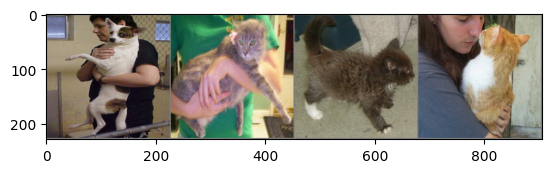

Dog   Cat   Cat   Cat  


In [49]:
#### 显示图片并打印图片标签
classes = ['Cat', 'Dog']

def imshow(image):
    image = image / 2 + 0.5
    npimg = image.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
images, labels = next(iter(train_loader))

imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [50]:
###   请同学们自己完成调用预训练的resnet18模型代码并修改输出
model = models.resnet18(pretrained=True)  # You can use a pre-trained model or create your own
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  # 2 classes: cat and dog

In [51]:
## 将模型加载至GPU
model = model.to(device)

In [52]:
####  定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [53]:
####   训练代码
train_losses = []

for epoch in range(200):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    train_losses.append(running_loss/ len(train_loader))
    
    print(f'Epoch: {epoch + 1} - Loss: {running_loss/ len(train_loader)}')

Epoch: 1 - Loss: 0.5062389127281192
Epoch: 2 - Loss: 0.35029947427594543
Epoch: 3 - Loss: 0.263981209979481
Epoch: 4 - Loss: 0.22001307474072002
Epoch: 5 - Loss: 0.18698118434125488
Epoch: 6 - Loss: 0.1617435493362455
Epoch: 7 - Loss: 0.12896773102841905
Epoch: 8 - Loss: 0.11593025297161394
Epoch: 9 - Loss: 0.09938909904582845
Epoch: 10 - Loss: 0.07847352754800556
Epoch: 11 - Loss: 0.07382773950101021
Epoch: 12 - Loss: 0.06471831944772304
Epoch: 13 - Loss: 0.05814985982277148
Epoch: 14 - Loss: 0.049415373092439416
Epoch: 15 - Loss: 0.04357063478653396
Epoch: 16 - Loss: 0.04042013428796729
Epoch: 17 - Loss: 0.04028591315921027
Epoch: 18 - Loss: 0.033662219942203635
Epoch: 19 - Loss: 0.036907115238533836
Epoch: 20 - Loss: 0.02921332343227352
Epoch: 21 - Loss: 0.0313144983831413
Epoch: 22 - Loss: 0.03017921005491862
Epoch: 23 - Loss: 0.027331294795217304
Epoch: 24 - Loss: 0.030774996979843323
Epoch: 25 - Loss: 0.018582984730618562
Epoch: 26 - Loss: 0.025029528116214686
Epoch: 27 - Loss: 0

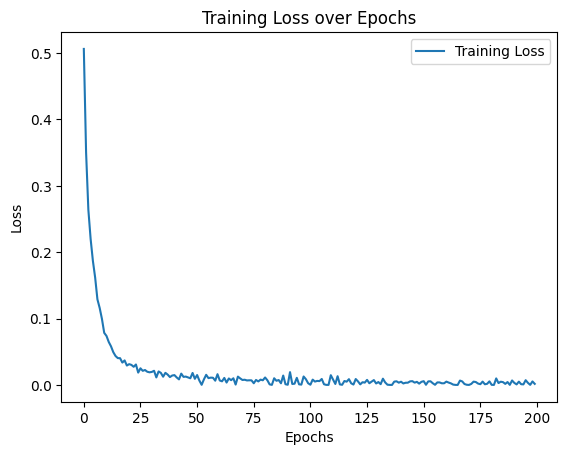

In [54]:
####  可视化
plt.plot(train_losses, label='Training Loss')
plt.title('Training Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [55]:
######   模型评估
model.eval()
correct = 0
total = 0
predicted_labels = []
true_labels = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        predicted_labels.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

accuracy = 100 * correct / total
print(f"Accuracy: {accuracy}%")

Accuracy: 94.06821552150272%


In [56]:
###  保存模型及路径
model_path = 'cats_dogs_classification.pth'

torch.save(model.state_dict(), model_path)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


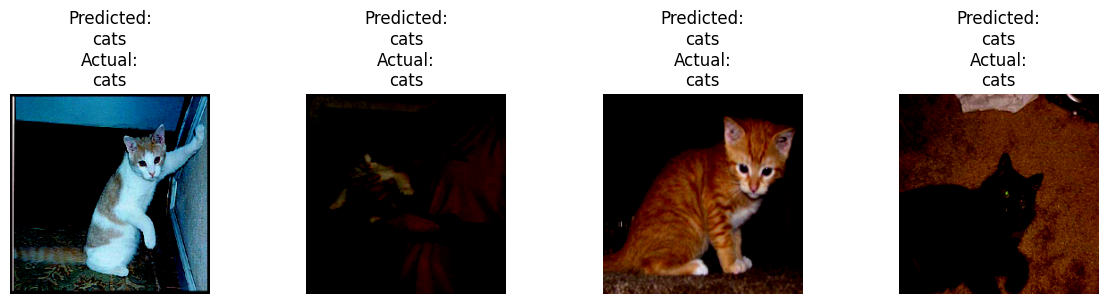

In [57]:
####  模型预测结果显示
class_labels = {0: 'cats', 1: 'dogs'}

model.eval()

images, labels = next(iter(test_loader))

images = images.to(device)
labels = labels.to(device)

outputs = model(images)
_, predicted = torch.max(outputs, 1)

num_images = len(images)
num_rows = num_images // 4  # Calculate the number of rows for subplots

fig, axes = plt.subplots(num_rows, 4, figsize=(12, 3 * num_rows))

for i, ax in enumerate(axes.flat):
    if i < num_images:  # Ensure the image index is within the available range
        image = np.transpose(images[i].cpu().numpy(), (1, 2, 0))
        ax.imshow(image)
        predicted_label = class_labels[predicted[i].item()]
        actual_label = class_labels[labels[i].item()]

        ax.set_title(f'Predicted:\n{predicted_label}\nActual:\n{actual_label}')
        ax.axis('off')

plt.tight_layout()
plt.show()

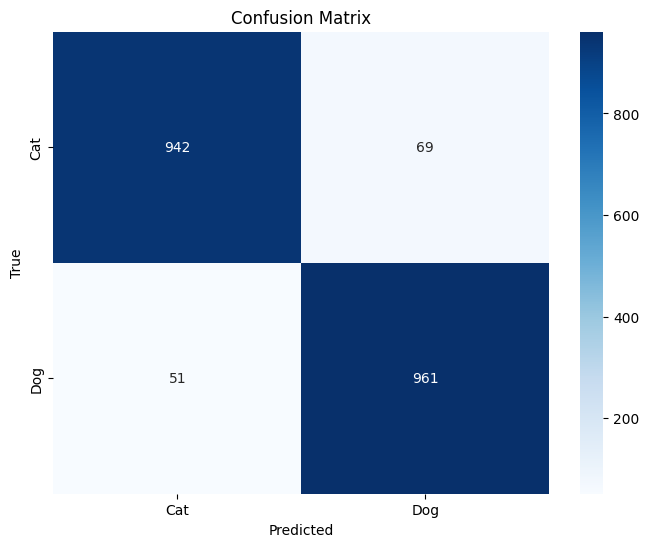

In [58]:
######   请同学们画出模型预测的混淆矩阵
conf_matrix = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()